# DATA SCIENCE CODING CHALLENGE

## Import data

In [1]:
# load all stations
stations <- read.table("retelaziostazionimonitoraggio.csv",sep=",",stringsAsFactors=F,header=T)

# load list of stations that ever logged a temperature
loggedStations <- read.table("logged.stations",stringsAsFactors=F, header=T, sep="\t")

#check if repeaters ever logged a measurement
print(paste("Number of repeaters measuring temperatures:",length(which(stations[,2] %in% loggedStations[,1] & stations[,1]!="Stazione"))))



[1] "Number of repeaters measuring temperatures: 0"


In [2]:
# 0 => thus keep only the stations, remove repeaters
stations <- stations[which(stations[,1]=="Stazione"),]
dim(stations)

[1] 235  13

in Bash, for each temperature file find out what stations record temperatures in each month
```bash
for f in T/*; do 
    cut -f 1 -d";" T/termoapr19.csv | sort | uniq > $f.stations; 
done
```
Comparing \*.stations files reveal that the set of stations is the same 173 stations each month. I stored that list in a file **logged.stations**

In [3]:
# read a list of stations that ever logged any measurement
loggedStations <- read.table("logged.stations",stringsAsFactors=F, header=T, sep="\t")

# check if all stations that ever logged a measurement are present in stattions table
loggedStations[which(!(loggedStations[,1] %in% stations[,2])),1]

[1] "Castello Vici"      "Lago di Corbara"    "Roma Sud"          
[4] "S.Cosimato-Mandela" "Sora"

The 5 stations above do not have a coordinates in the stations table and so they either have to be removed from the further analysis or their location data fixed.
I am opting for the later.
The original table **retelaziostazionimonitoraggio.csv** is manually extended with imputed data as follows:

- *Castello Vici*: google search identifies a meteo station location... 
see www.researchgate.net/figure/Figura-5-Anagrafica-del-pluviometro-Castello-Vici-del-CF-della-Regione-Lazio-che_fig2_321756759
- *Lago di Corbara*: coordinates of "42.710014","12.260151","140" on the lake shore are chosen
- *Roma Sud*: there is a station named *Tor Marancia* in south Rome that never reports any measurement, so I renamed *Tor Marancia* station to Roma Sud
- *S.Cosimato-Mandela* and *Sora* stations are imputed using the google map search

The result is stored in the **stations+missing.csv** file.


In [4]:
stations <- read.table("stations+missing.csv",sep=",",stringsAsFactors=F,header=T)
stations <- stations[which(stations[,1]=="Stazione"),]

# check again if all stations that ever logged a measurement are present in the stations table now
loggedStations[which(!(loggedStations[,1] %in% stations[,2])),1]
# empty array returned => good now, we have location data for all stations

# Drop data about stations that we do not have any temperatures measurements for:
# as they are no useful for further analysis
stations <- stations[which(stations[,2] %in% loggedStations[,1]),]
dim(stations)
# we are left with 173 stations

character(0)

[1] 173  13

I checked the completness of measuremnts in bash
```bash
for f in T/*; do 
    echo -n "$f  "; 
    tail -n +2 $f | cut -f 1 -d";" | sort | uniq -c | awk '{print $1}' | sort | uniq -c; 
done
```
returned:

`T/termoapr19.csv      173 30
T/termodic2018.csv      173 31
T/termofeb19.csv      173 28
T/termogen19.csv      173 31
T/termogiu19.csv      173 30
T/termomag19.csv      173 31
T/termomar19.csv      173 31
T/termonov2018.csv      173 30
T/termoott2018.csv      173 31
T/termosett2018.csv      173 30`

Looking on the above numbers we can see that we have a complete records for all 173 stations for each day of month, still possibly some values are listed as "-" instead of a numeric temperature, but we have a record for each station and eah day, so we can simply concatenate month files to single datafile.
First replace "-" temperatures with NA and commas with periods
```bash
sed -i -e 's/;-;/;NA;/g' -e 's/,/./g' T/*
```
Now paste the individual files into a single file and sort:
```bash
for f in T/termosett2018.csv T/termoott2018.csv T/termonov2018.csv T/termodic2018.csv T/termogen19.csv T/termofeb19.csv T/termomar19.csv T/termoapr19.csv T/termomag19.csv T/termogiu19.csv; do 
    tail -n +2 $f; 
done |  sort -k1,1 -s -t";" > temperatures.csv
```

Then, in a text editor, I manualy fixed one missing end of a line and also in June 2019 added NAs for max temperatues of S.Cosimato-Mandela as only minimal temperatures were recorded (even the "-" symbol was missing there).

File **temperatures.csv** contains a station/day combination per each row, 52K rows total. Let's combine all measurements for each station into a single row:
```bash
    awk -v FS=";" '{if($1!=old) { print ""; printf("%s,%s,%s,",$1,$3,$4)} else { printf("%s,%s,",$3,$4) } old=$1 }' temperatures.csv > temperatures_series.csv
```

**temperatures_series.csv** has now 173 rows of temperature measurements, each row for one station. Within each row temperatures are ordered as `station_name, minT_of_09/01/2018, maxT_of_09/01/2018, .... minT_of_06/30/2019, maxT_of_06/30/2019`

## Load temperature data to R

In [5]:
Tseries <- read.csv("temperatures_series.csv",colClasses=c("character",rep("numeric",606)),stringsAsFactors=F,header=F)
print(dim(Tseries))
N=dim(Tseries)[1]  # number of stations
M=dim(Tseries)[2]  # number of days

#both stations and Tseries table have 173 rows but in different order... fix that 
mapping <- rep(0,N)
for (i in 1:N) 
    mapping[i] <- which(stations[,2]==Tseries[i,1])

stations <- stations[mapping,]

[1] 173 607


## 1. Simple statistics

Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“Removed 586 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 556 rows containing non-finite values (stat_ydensity).”

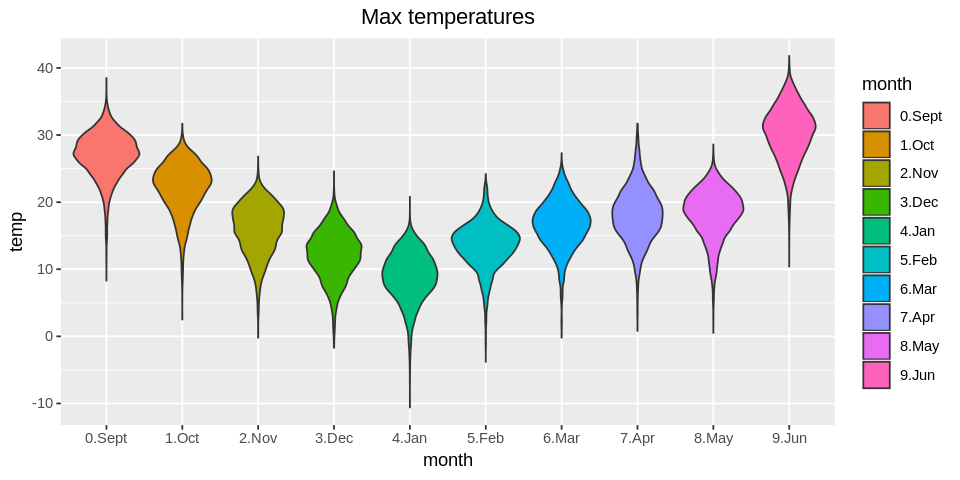

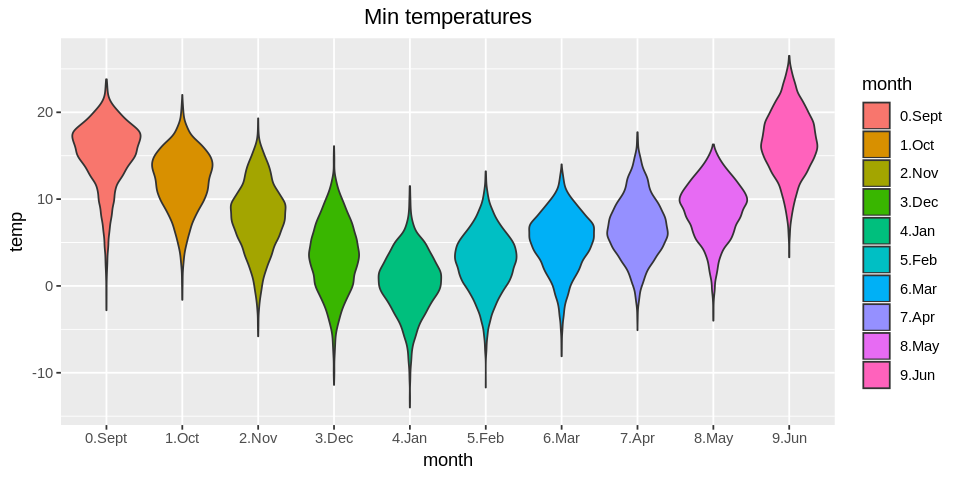

In [6]:
# Library
require(ggplot2)

getMaxData <- function(start,end){
    return (as.vector(as.matrix(Tseries[,2*(start:end)+1])))
}

getMinData <- function(start,end){
    return (as.vector(as.matrix(Tseries[,2*(start:end)+0])))
}

# create a datasets
monthData=rep(c( rep("0.Sept",30), rep("1.Oct",31), rep("2.Nov",30), rep("3.Dec",31), rep("4.Jan",31), 
          rep("5.Feb", 28), rep("6.Mar",31), rep("7.Apr",30), rep("8.May",31), rep("9.Jun",30)), each=N)

maxData <- data.frame(
  month=monthData,
  temp=c( getMaxData(1,30), getMaxData(31,61), getMaxData(62,91), getMaxData(92,122), getMaxData(123,153),
           getMaxData(154,181), getMaxData(182,212), getMaxData(213,242), getMaxData(243,273), getMaxData(274,303)))

minData <- data.frame(
  month = monthData,
  temp=c( getMinData(1,30), getMinData(31,61), getMinData(62,91), getMinData(92,122), getMinData(123,153),
           getMinData(154,181), getMinData(182,212), getMinData(213,242), getMinData(243,273), getMinData(274,303)))

# Most basic violin chart
pMax <- ggplot(maxData, aes(x=month, y=temp, fill=month)) + # fill=name allow to automatically dedicate a color for each group
  geom_violin() + ggtitle("Max temperatures") +
  theme(plot.title = element_text(hjust = 0.5))

pMin <- ggplot(minData, aes(x=month, y=temp, fill=month)) + # fill=name allow to automatically dedicate a color for each group
  geom_violin() + ggtitle("Min temperatures") +
  theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width=8, repr.plot.height=4)
pMax
pMin

[1] 32

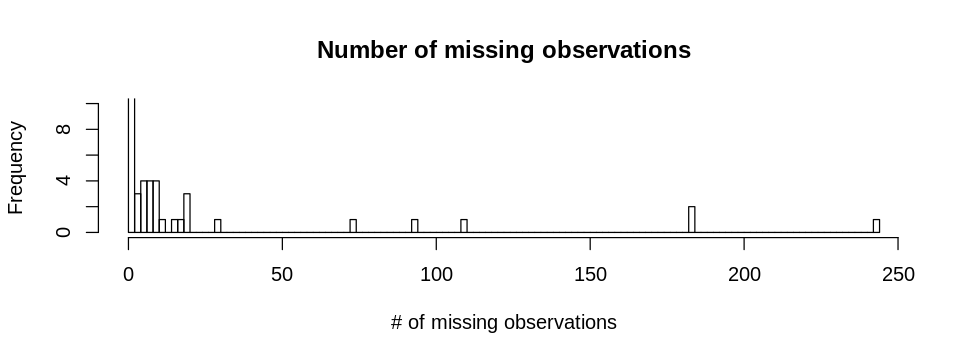

In [7]:
numberOfmissings = rep(0,N)
for (i in 1:N)
    numberOfmissings[i] = sum(is.na(Tseries[i,2:M]))
options(repr.plot.width=8, repr.plot.height=3)
hist(numberOfmissings,breaks=100, main = "Number of missing observations", xlab="# of missing observations",ylim=c(0,10))
sum(numberOfmissings>0)

## 2a Climatic Map

In order to start cluster analysis of the weather stations we first have to impute the missing values.

### IMPUTING MISSING VALUES

#### Find  neighboring stations for each station

[1] 6

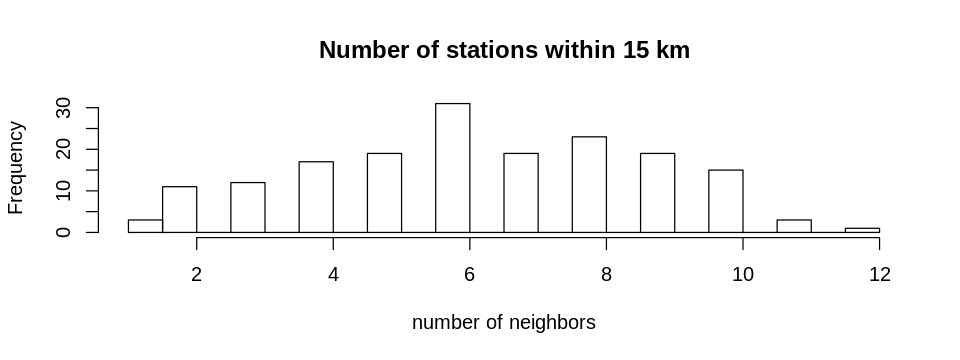

In [8]:
# convert longitude and latitude to km distances so we can calculate accrate distances between stations
# conversion constants of 111 and 83 for Lazio region were found here: https://www.nhc.noaa.gov/gccalc.shtml
kmStations <- stations
kmStations[,3] <- 111* stations[,3]
kmStations[,4] <- 83* stations[,4]

# get distance matrix
stationsDist <-  as.matrix(dist(kmStations[,3:4]))  

# For each station find number of stations within distance X, 
# within the radius X=15 km, stations get on average 6 neighbouring station, 
# which is a reasonable number for to impute missing temperature values from
nn <- rep(0,N)  # nn is an array, storing the number of stations within X kms from each station
for(i in 1:N) 
    nn[i] <- sum(stationsDist[i,]<15)
options(repr.plot.width=8, repr.plot.height=3)
hist(nn,breaks=20, main = "Number of stations within 15 km", xlab="number of neighbors")
median(nn)

#### Imputing missing temperature values from neighboring stations

For each station generate list of stations within 15 km

In [9]:
maxDistance = 15
closestStations <- list()
closestDistances <- list()
for (i in 1:N){
    closestStations[[i]] <- which(stationsDist[i,]<maxDistance & stationsDist[i,]>0)
    if(length(closestStations[[i]])==0){
        # IF there are no neighbors within 15 km
        # THEN get then single closest station only
        closestStations[[i]] <- order(stationsDist[i,])[2] # 1 is myeslef, 2 is closest exluding myself
    }
    closestDistances[[i]] <- stationsDist[i,closestStations[[i]]]
}

#### Now use the neighboring stations to impute missing values

In [10]:
# For each station two linear imputation models from the temperatures of their neighbors are trained
# one model for Max temperatures and one for Min temperatures
imputeMissingValues <- function(station, neighbors){
    stationValues <- Tseries[station,]
    w <- which(is.na(stationValues))
    
    # if there are missing values
    # train local linear imputation models for given station
    # and then impute the data
    if (length(w)>0){
        # train linear model of station Max temperature from neighoring temperatures
        maxData <- t(Tseries[c(station,neighbors),2*(1:303)+1])
        colnames(maxData)[1] = "target"
        maxData <- data.frame(maxData)
        # obsreved Max temperatures
        wC <- which(!is.na(maxData[,1]))
        maxModel = lm(target ~ .,data=maxData[wC,])  # train model only on complete data
        
        # train linear model of station Min temperature from neighoring temperatures
        minData <- t(Tseries[c(station,neighbors),2*(1:303)+0])
        colnames(minData)[1] = "target"
        minData <- data.frame(minData)
        # obsreved Min temperatures
        wC <- which(!is.na(minData[,1]))
        minModel = lm(target ~ .,data=minData[wC,])  # train model only on complete data
        
        
        for(j in 1:length(w)){
            if (w[j]%%2==1)
                newValue = predict(maxModel,maxData[(w[j]-1)/2,]) 
            else
                newValue = predict(minModel,minData[w[j]/2,])
            
            # if some of the neighbors had missing temperature value too the prediction will be NA
            # thus we just simply average non missing values of other neighbors then
            if (is.na(newValue))
                newValue = mean(Tseries[neighbors,w[j]],na.rm=T)
            
            stationValues[w[j]] = newValue
        
        }
    }
    return(stationValues)
}


# now impute missing values for each station
tmpData <- Tseries
for(i in 1:N){
    tmpData[i,] <- imputeMissingValues(i, closestStations[[i]])
}
# copy all imputed to the original location... 
# it is important that this is done only once all imputations are finished
Tseries <- tmpData

### Clustering the stations by their temperature profiles

We have imputed all missing values, so can start cluster analysis.

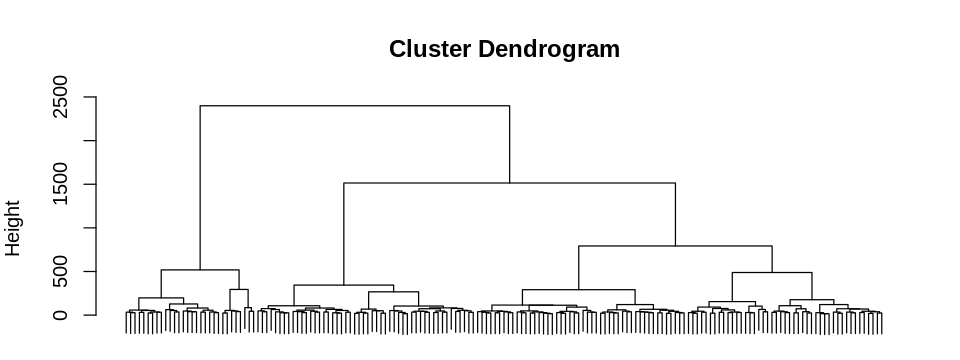

In [11]:
# calculate distances among stations and perform hierarchical clustering
tempDist <- dist(Tseries[,2:M])

# based on the paper: REDEFINING THE CLIMATE ZONES OF TURKEY USING CLUSTER ANALYSIS 
# https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/joc.910
# hierarchical clustering with Ward's minimum variance method was used to determine clustering of the stations. 
# According to my subjective evaluation this also performed favorable to other merging methods I tried. 

options(repr.plot.width=8, repr.plot.height=3)
hc <- hclust(tempDist,method="ward.D")
par(mar=c(0, 4, 4, 2))
plot(hc,xlab=NA,sub=NA,labels=F)

Ward method generated fairly well separated 5 clusters (see the cluster dendogram above). So I will split Lazio region to 5 climatic regions


In [12]:
clusterOf5 <- cutree(hc,k=5)

Check annual mean day and night temperatures in the resulting clusters

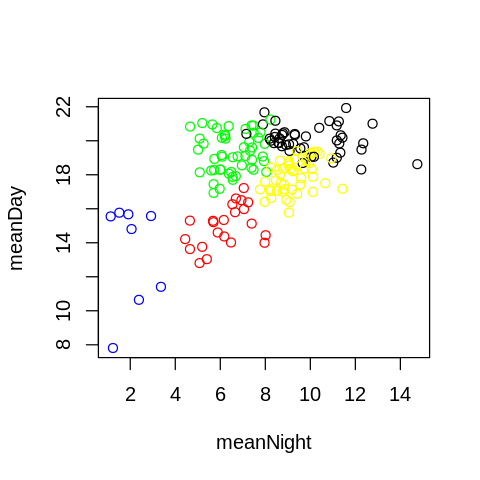

In [13]:
# let's calculate annual mean of day and night temperatures for each station 
meanNight <- rep(0,N)
meanDay <- rep(0,N)
for(i in 1:N) 
    meanNight[i] <- mean(as.numeric(Tseries[i,0+2*(1:303)]))
for(i in 1:N) 
    meanDay[i] <- mean(as.numeric(Tseries[i,1+2*(1:303)]))

# my colors array
cbPalette <- c("red","green","yellow","blue","black")

# double check clustering of station in annual mean day/night temperature space
options(repr.plot.width=4, repr.plot.height=4)
plot(meanNight,meanDay,col=cbPalette[clusterOf5])

### Prepare data for overlay over google maps and export:

In [14]:
D <- cbind(cbind(cbind(stations,cbPalette[clusterOf5]),1:173),rep("circle1",173))
write.table(D[,c(3,4,16,14,15,2)],file="data.for.google.csv",quote=F,row.names=F,col.names=F,sep="\t")

Resullt:  (based on www.hamstermap.com/custommap.html)
![title](./Lazio.png)
 
 The clusters are kind of nicely separated geographically as:
 - **<font color='black'>&#9679;</font> black**: coastal climate (hot in both night and day)
 - **<font color='green'>&#9679;</font> green**: warm days but nights get colder as farther from the sea
 - **<font color='yellow'>&#9679;</font> yellow**: somehow colder during the day, but still close to sea so nights are warmer
 - **<font color='red'>&#9679;</font> red**: I guess mountains... colder both day and night
 - **<font color='blue'>&#9679;</font> blue**: same as red but nights are about 4 degrees colder


In [15]:
# Now lets use KNN: to color code the whole map
# First download Italy regions border coordinates from https://www.gadm.org
# stored localy in the file: gadm36_ITA_1_sp.rds

# install "sp" package if not installed yet
list.of.packages <- c("sp")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)

require(sp)
rds1 <- readRDS("gadm36_ITA_1_sp.rds")

# get the border of the mainland Lazio region, ignoring the islands for the sake of simplicity now
border <- rds1@polygons[[8]]@Polygons[[7]]@coords

# get min/max of X.Y and prepare set of all points within the Lazio borders on 200x200 grid
xmax <- max(border[,1]);  ymax <- max(border[,2]);   xmin <- min(border[,1]);   ymin <- min(border[,2])
xx <- c()
yy <- c()
for (x in seq(xmin,xmax,length.out=200))
    for (y in seq(ymin,ymax,length.out=200)){
      xx <- c(xx,x)
      yy <- c(yy,y)  
    }

# now filter only points that are within Lazio region 
isIn <- point.in.polygon(xx,yy,border[,1],border[,2])
xx <- xx[which(isIn>0)]
yy <- yy[which(isIn>0)]

Loading required package: sp


Loading required package: class


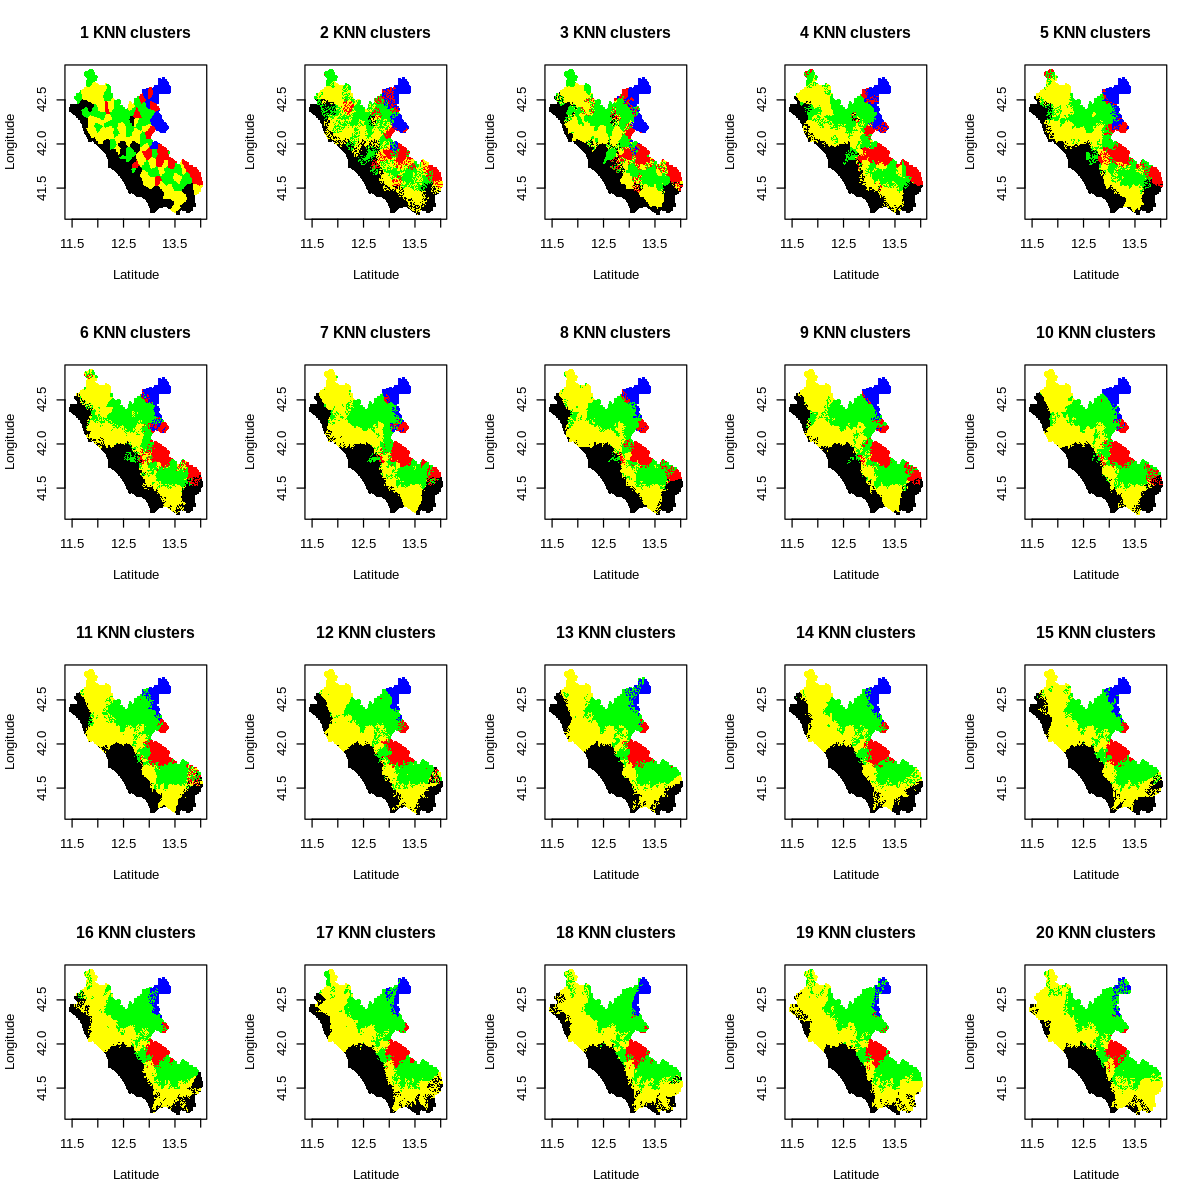

In [16]:
# now perform KNN clustering of xx,yy points
# use 83 and 111 scaling constants to have location in km rather than longitude and latitude degrees
require(class)
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow=c(4,5))

# see how does it look for different number of neighbors (K)
for(k in 1:20){
   col <- knn(cbind(83*stations[,4],111*stations[,3]),cbind(83*xx,111*yy),cl=clusterOf5,k=k)
   plot(xx,yy,pch=".",col=cbPalette[col],cex=3.0, xlab="Latitude",ylab="Longitude",main=paste(k,"KNN clusters"))
}

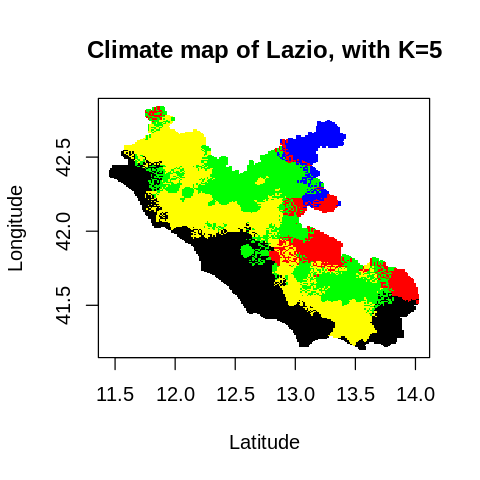

In [17]:
# Looks like with K about 5 the resulting map looks reasonable 
# (not too much noisy, and still preserving most of the local features)
k=5
col <- knn(cbind(83*stations[,4],111*stations[,3]),cbind(83*xx,111*yy),cl=clusterOf5,k=k)

options(repr.plot.width=4, repr.plot.height=4)
par(mfrow=c(1,1))
plot(xx,yy,pch=".",col=cbPalette[col],cex=3.0, xlab="Latitude",ylab="Longitude",main="Climate map of Lazio, with K=5")

## 2b) Estimate temperature recordings in S Angelo Romano 

Sant Angelo Romano is located almost exactly in the middle of a triangle of other 3 meteo stations (Monterotondo, Guidona, Palombara). See:
![title](./SAngelo.png)

Also both day and night temperatures of those 3 stations are copying each other well:

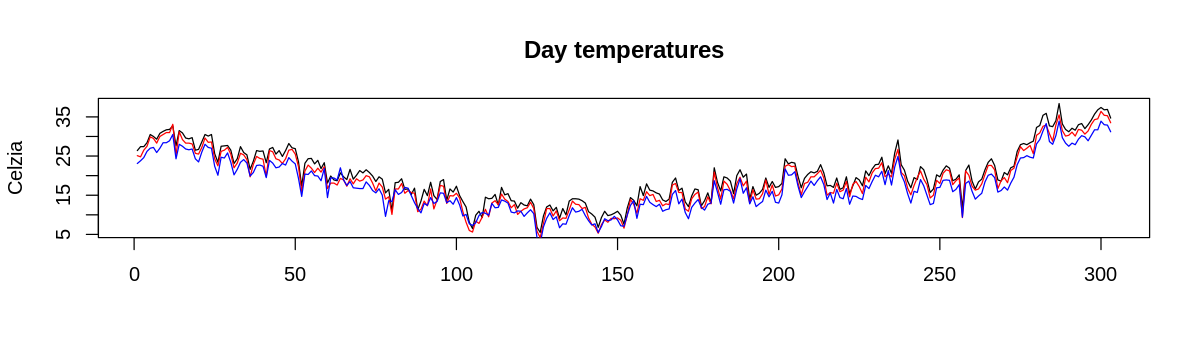

In [18]:
options(repr.plot.width=10, repr.plot.height=3)
plot(as.numeric(Tseries[60,2*(1:303)+1]),type="l",main="Day temperatures",ylab="Celzia",xlab=NA)
lines(as.numeric(Tseries[88,2*(1:303)+1]),type="l",col="red")
lines(as.numeric(Tseries[100,2*(1:303)+1]),type="l",col="blue")

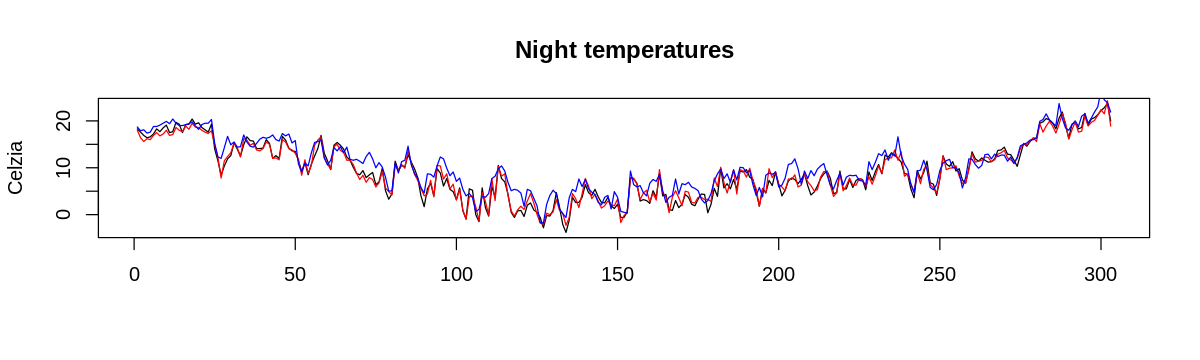

In [19]:
options(repr.plot.width=10, repr.plot.height=3)
plot(as.numeric(Tseries[60,2*(1:303)+0]),type="l",main="Night temperatures",ylab="Celzia",xlab=NA)
lines(as.numeric(Tseries[88,2*(1:303)+0]),type="l",col="red")
lines(as.numeric(Tseries[100,2*(1:303)+0]),type="l",col="blue")

Interestingly though, despite the temeratures profiles have the same trend, still clear systematic shifts can be observed. Palombara station is consistenly few degrees cooler in the day, but is actually the warmest place during the nights.
Looking on the geographical details, St. Angelo Romano is also a hill very much like Palombara, still Palombara is located just at the foot of a larger mountain, which is not the case for St. Angelo R. So I would estimate the recordings at St. Angelo R as a weighted mean of the 3 nearby stations. One could do various sophisticated models to estimate "proper weights", but my guess is that the difference is rather not worth the effort. So I would simply use $$T_{SAngelo} = 0.55T_{Palombara} + 0.3T_{Monterotondo} + 0.15T_{Guidonia}.$$ 
Guidonia having the lowest weight as its altitude is lowest of all 4 considered places.


In [20]:
res = 0.55 * Tseries[100,2:607] + 0.3 * Tseries[88,2:607] + 0.15 * Tseries[60,2:607]
write.table(matrix(res,ncol=2,byrow=T),file="SAngeloRomano.csv",quote=F,sep=";",col.names=F,row.names=F)
# see the resulting file on the disk (massaged in bash to proper format)

## 3 Pump Gain
I assume that the pump is supposed to work 12 months a year. So, in order to estimate annual pump gains, we need at least a rough temperature estimates for each station for months of July and Ausgust as we do not have any data recorded for those months. I do that by simply fitting a cosine like function to min and max recordings of each station and then extrapolating to July and Ausgust. This shall on average be good enough estimate of pump gains in those months, luckily no risk of freezing in the summer.

In [21]:
# function to calculate economical gain of a pump from a an array of annual temperatures
PumpGain <- function(tempData){
    freezePoint = -3
    gain = 0
    for(i in 1:(length(tempData)/2)){
       if(tempData[2*i-1]>(freezePoint)){
           gain = gain + (tempData[2*i] - tempData[2*i-1])
       }else
           gain = gain - 30
    }
    return(gain)
}

In [22]:
# cosine function - scaled shifted
cosFunction <- function(A,B,t0,t){
   return (A + B*cos(2*pi*(t+t0)/365))
}

# Goodess of fit function of cosine fit to empirical data
costFunctionCos <- function(x){
    days = 303
    A=x[1]
    B=x[2]
    t0=x[3]
    S=0

    for(i in 1:days)
        S = S + (cosFunction(A,B,t0,i)  - cosData[i]  )^2
    return(S)
}

In [23]:
# Function that preditcts approximate temperature data for July and August 
PredictJulyAugustData <- function(station){
    julyAugustDays <- 304:365
    
    cosData <<- as.numeric(Tseries[station,2*(1:303)+1])
    myCosParams1 <- optim(c(10,20,50),costFunctionCos)$par
    
    cosData <<- as.numeric(Tseries[station,2*(1:303)+0])
    myCosParams2 <- optim(c(0,15,50),costFunctionCos)$par
    
    julyAugustMaxTemps <- cosFunction(myCosParams1[1],myCosParams1[2],myCosParams1[3], julyAugustDays)
    julyAugustMinTemps <- cosFunction(myCosParams2[1],myCosParams2[2],myCosParams2[3], julyAugustDays)
        
    result <- c()
    for(ii in 1:length(julyAugustMaxTemps))
        result <- c(result,julyAugustMinTemps[ii],julyAugustMaxTemps[ii])
    return(result)
}

### Example plot of fitting with a cosine fit for the summer

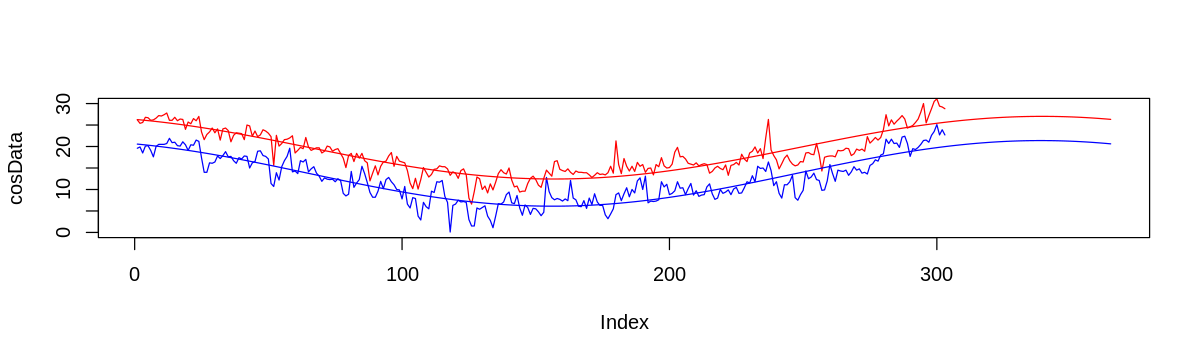

In [24]:
station=6
cosData <<- as.numeric(Tseries[station,2*(1:303)+1])
myCosParams <- optim(c(10,20,50),costFunctionCos)$par
options(repr.plot.width=10, repr.plot.height=3)
plot(cosData,type="l",xlim=c(1,365),ylim=c(0,30),col="red")

cosData <<- as.numeric(Tseries[station,2*(1:303)+0])
myCosParams2 <- optim(c(0,15,50),costFunctionCos)$par
lines(1:303,cosData,col="blue")

days <- 1:365
lines(days,cosFunction(myCosParams[1],myCosParams[2],myCosParams[3],days),type="l",col="red")
lines(days,cosFunction(myCosParams2[1],myCosParams2[2],myCosParams2[3],days),type="l",col="blue")

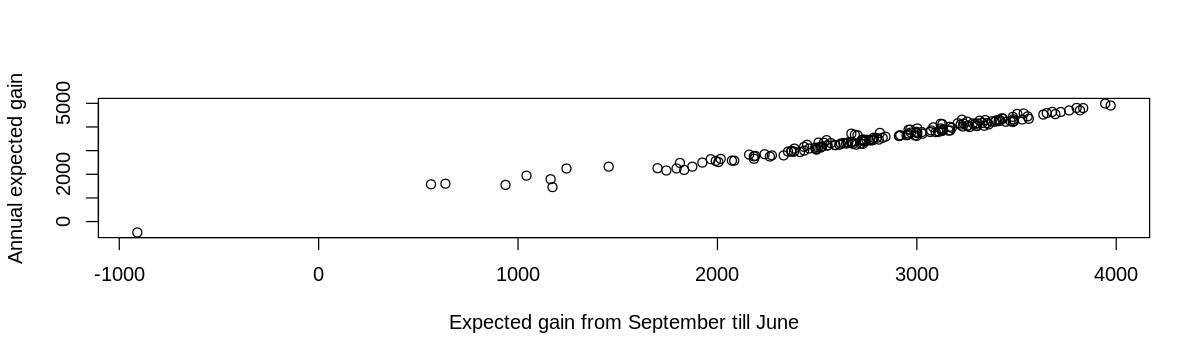

In [25]:
pumpIncome1 <- rep(NA,N)  # pump gain data, per station, ignoring the summer
pumpIncome2 <- rep(NA,N)  # pump gain data, per station, including the summer
for (i in 1:N){
    julyAugustData <- PredictJulyAugustData(i)
    temperatureData = c(as.numeric(Tseries[i,2:M]),julyAugustData)
    pumpIncome1[i] <- PumpGain(Tseries[i,2:M])
    pumpIncome2[i] <- PumpGain(temperatureData)
}

# scatter plot comparing two gain calculations, more less the same pattern, except of few details
plot(as.numeric(pumpIncome1),as.numeric(pumpIncome2),
     xlab="Expected gain from September till June",
     ylab="Annual expected gain")

In [26]:
# If we ignore the summer, this station would be an ideal spot for the pump
stations[which.max(pumpIncome1),2]

[1] "Borgo Montello"

In [27]:
# If we assue the pump is running also in the summer, this station would be an ideal spot for the pump
stations[which.max(pumpIncome2),2]

[1] "Fianello"

## 4a Predicting minimal temperature of a day

In [28]:
# number of past days to use for temperature features
Ndays <- 4

# get min/max/mean of night and day temparature on given date 
# so a vector of 6 numbers is returned
getLazioMinMaxOfADay <- function(day){
    minTemps=Tseries[,2*day+0]
    maxTemps=Tseries[,2*day+1]

    mm1 = min(minTemps); MM1 = max(minTemps); avg1 = mean(minTemps); 
    mm2 = min(maxTemps); MM2 = max(maxTemps); avg2 = mean(maxTemps);

    return(c(mm1,MM1,avg1,mm2,MM2,avg2))
}

# For a given day, return a matrix of all my model fearures for all stations
# output of shape Nx31
getFeaturesOfAllStationsForAGivenDay <- function(day){
    dayFeatures = cbind(Tseries[,(2*(day-Ndays)):(2*(day-1)+1)],  # temperatures of previous Ndays at my location
                        stations[,3:5],  # x,y,z coordinates 
                        matrix(cos(2*pi*(day+30)/365),nrow=N,ncol=1), # day of the year cocine transformed
                        matrix(sin(2*pi*(day+30)/365),nrow=N,ncol=1), # day of the year sine transformed
                        matrix(c(getLazioMinMaxOfADay(day-1), 
                                 getLazioMinMaxOfADay(day-2),
                                 getLazioMinMaxOfADay(day-3)),nrow=N,ncol=18,byrow=T))
    colnames(dayFeatures) = c(paste(rep(c("Tmin","Tmax"),Ndays),rep(-Ndays:-1,each=2)), 
                              "lattitude","longitude","altitude","cosT","sinT",
                              "minN1","maxN1","avgN1","minD1","maxD1","avgD1",
                              "minN2","maxN2","avgN2","minD2","maxD2","avgD2",
                              "minN3","maxN3","avgN3","minD3","maxD3","avgD3")
    return(dayFeatures)
}


# prepare feature vecor for each day
myFeatures <- c() # feature vector for all station/day combinations (has 299*173=51727 rows)
myMinTemps <- c()  # actual measured minimal temperature for each station/day
for(t in (Ndays+1):303){
    dayFeatures = getFeaturesOfAllStationsForAGivenDay(t)
    myFeatures = rbind(myFeatures,dayFeatures)  # append day features to the feature table 
    myMinTemps = rbind(myMinTemps, as.matrix(Tseries[,2*t])) # append measured minTemperatures
}

Now I am showing how performance of my model improves by adding more and more features. Persormance is measured as a mean absoulte difference between the predicted and actual temperature.

##### Model1: based only on time of the year

In [29]:
fit1 <- lm(myMinTemps ~ cosT + sinT, myFeatures)
mean(abs(predict(fit1,myFeatures)-myMinTemps))

[1] 2.853319

##### Model2: based only on time of the year + location

In [30]:
fit2 <- lm(myMinTemps ~ cosT + sinT + lattitude + longitude + altitude, myFeatures)
mean(abs(predict(fit2,myFeatures)-myMinTemps))

[1] 2.52934

##### Model3: with added minT of previous day

In [31]:
fit3 <- lm(myMinTemps ~ ., myFeatures[,c(7,9:13)])
mean(abs(predict(fit3,myFeatures)-myMinTemps))

[1] 1.645527

##### Model4: extended with minT,maxT of previous 4 days

In [32]:
fit4 <- lm(myMinTemps ~ ., myFeatures[,1:13])
mean(abs(predict(fit4,myFeatures)-myMinTemps))

[1] 1.59887

##### Model5: further adding min,max,avg temperatures of previous day over all stations

In [33]:
fit5 <- lm(myMinTemps ~ ., myFeatures[,1:19])
mean(abs(predict(fit5,myFeatures)-myMinTemps))

[1] 1.544938

##### Model6:  adding min,max,avg temperatures of previous 3 days over all stations

In [34]:
fit6 <- lm(myMinTemps ~ ., myFeatures)
mean(abs(predict(fit6,myFeatures)-myMinTemps))

[1] 1.500629

Stopping here... the gains by adding additional features to the model are rather minimal, our expected error of prediction of Tmin is 1.5 degrees. Originaly I thought of spliting the data to train/test set and do proper performance estimation on a test set. But first it is hard to plit the data into independent test and train set. Moreless we have only one winter season in the data and temperatures of different stations are very much correlated (especially those geographically near). The other point is that having only daily min/max temperatures is not data that is suficient to do accurate temperature prediction anyway 

[1] "Features in decreasing importance:"


[1] "cosT"      "lattitude" "Tmin -1"   "longitude" "maxD1"     "avgN1"    
 [7] "maxN1"     "sinT"      "avgD1"     "minD1"     "minN1"     "maxN3"    
[13] "avgD2"     "minD2"     "Tmin -3"   "avgN2"     "Tmin -2"   "avgN3"    
[19] "maxN2"     "maxD3"     "minD3"     "Tmax -2"   "Tmax -1"   "Tmax -4"  
[25] "maxD2"     "minN3"     "Tmin -4"   "minN2"     "Tmax -3"   "altitude"

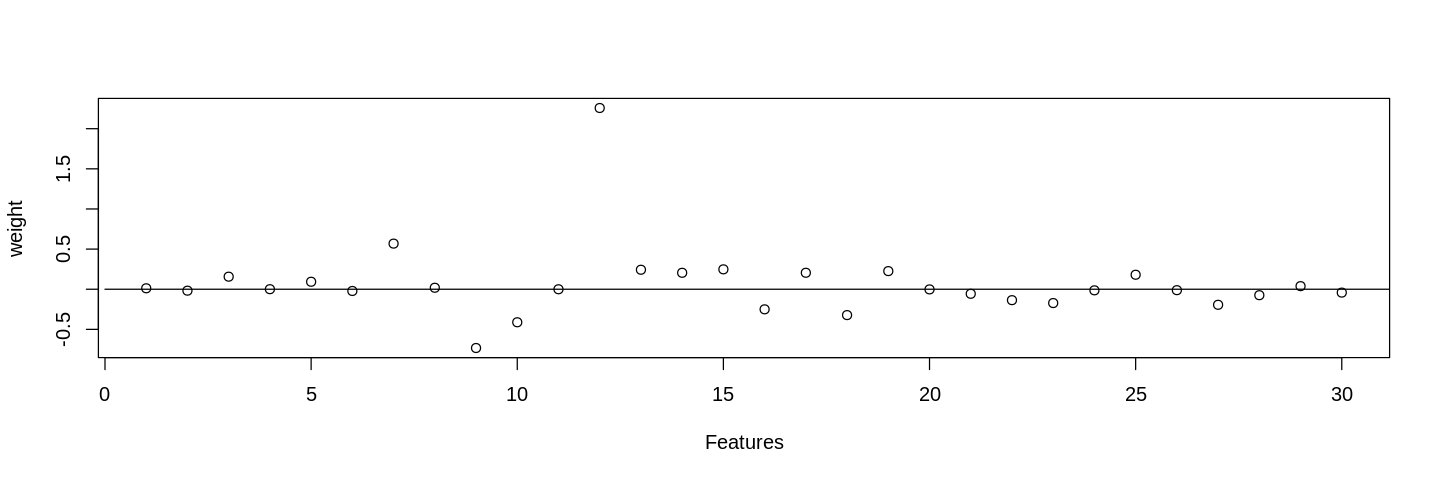

In [35]:
options(repr.plot.width=12, repr.plot.height=4)
print("Features in decreasing importance:")
colnames(myFeatures)[order(abs(fit6$coefficients[2:31]),decreasing=T)]
plot(fit6$coefficients[2:31],xlab="Features",ylab="weight")
lines(c(0,40),c(0,0))

### Calculating probability that $T_{min}$ will be lower than -3 as a function of predicted $T_{min}$

In [36]:
minPrediction = predict(fit6,myFeatures)
temp <- seq(-20,20,by=0.1)
Probability <- temp
for (i in 1:401)
    Probability[i] = mean(myMinTemps[which(minPrediction<(temp[i]+.5) & minPrediction>(temp[i]-.5))]<=(-3))
Probability[which(is.nan(Probability))]=1

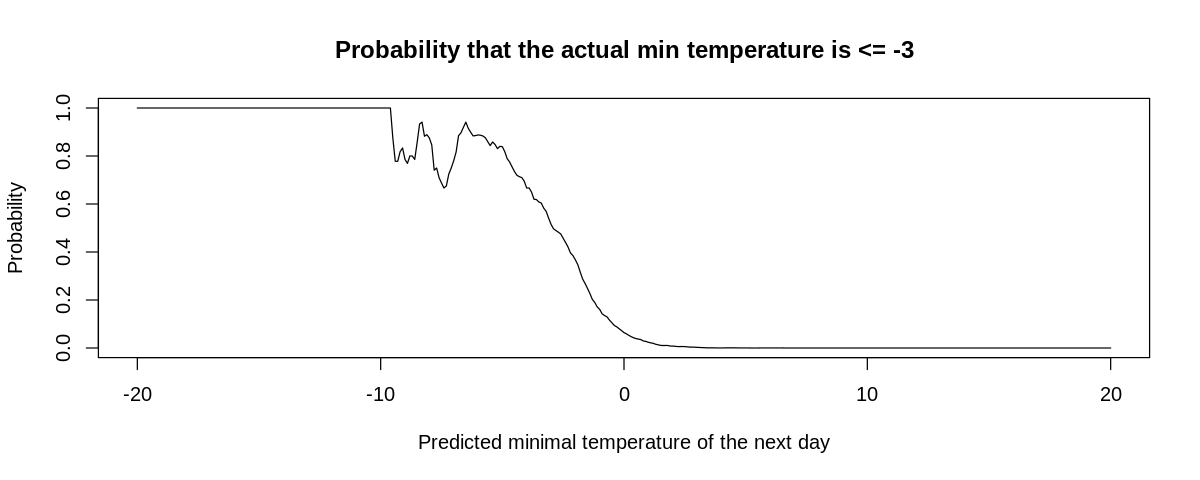

In [37]:
options(repr.plot.width=10, repr.plot.height=4)
plot(temp,Probability,type="l",main="Probability that the actual min temperature is <= -3",
     ylab="Probability",xlab="Predicted minimal temperature of the next day")

In [38]:
temp[which.min(Probability>=0.1)]

[1] -0.4

Based on empirical data, if predicted temperature is -0.4 lower, then it is at least 10% chance that actual temperature will be lower than -3.

### Calculating expecting gain under the new model

In [39]:
#function that provides features only for 10 months that we actually have data
#I would assume that probability of freezing in July and August is 0 anyway  
getFeaturesOfAGivenStationForAllDays <- function(station){
    indeces <- seq(0,N*298,by=N) + station
    return(myFeatures[indeces,])
}


# function to calculate economical gain of a pump
PumpGainPredictionBased <- function(tempData,features){
    freezePoint = -3
    gain = 0
    
    predictedMinTemperature <- predict(fit6,features)
    
    for(i in 5:303){
        if (predictedMinTemperature[i-4] > (-0.4)){  
           if(tempData[2*i-1]>(freezePoint)){
               gain = gain + (tempData[2*i] - tempData[2*i-1])
           }else
               gain = gain - 30
        }
    }
    
    # add gain from first 4 days of September and July and August the original way
    # anyway the probabbility of hitting -3 on those days is practically 0.
    for(i in c(1:4, 304:365)){
       if(tempData[2*i-1]>(freezePoint)){
           gain = gain + (tempData[2*i] - tempData[2*i-1])
       }else
           gain = gain - 30
    }
    
    return(gain)
}

#### Now calculate expected gain at each station location

In [40]:
pumpIncome2B <- rep(NA,N)
for (i in 1:N){
    julyAugustData <- PredictJulyAugustData(i)
    temperatureData = c(as.numeric(Tseries[i,2:M]),julyAugustData)
    features <- getFeaturesOfAGivenStationForAllDays(i)
    pumpIncome2B[i] <- PumpGainPredictionBased(temperatureData,features)
}

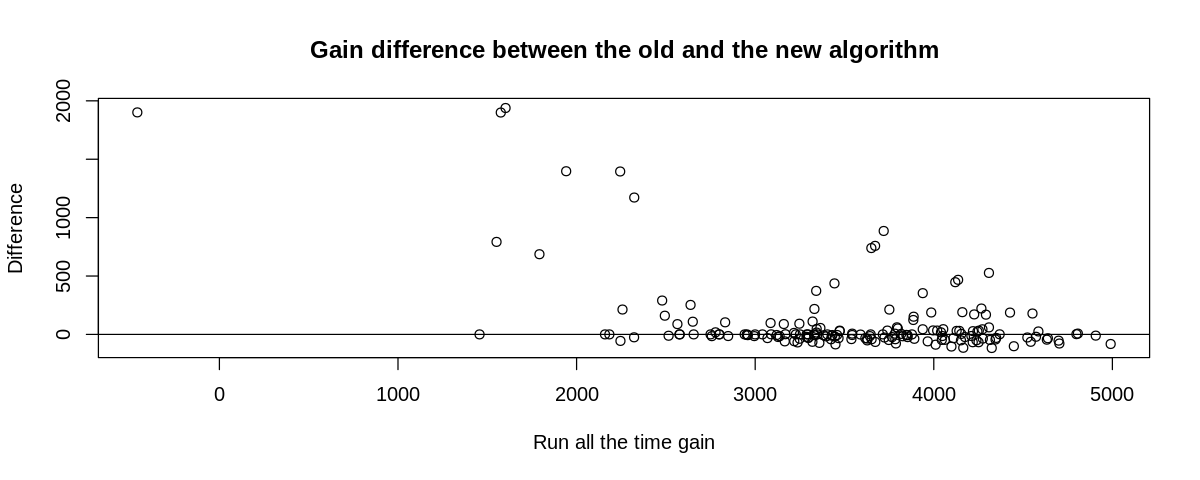

In [41]:
plot(as.numeric(pumpIncome2),as.numeric(pumpIncome2B)-as.numeric(pumpIncome2),
    main="Gain difference between the old and the new algorithm",ylab="Difference",xlab="Run all the time gain")
lines(c(-1e3,1e4),c(0,0))

In [42]:
ss <- which.max(pumpIncome2B)
print(paste("Optimal station is",stations[ss,2]))
print(paste("Original expected gain:",pumpIncome2[ss]))
print(paste("Gain under 10% risk parameter:",pumpIncome2B[ss]))

[1] "Optimal station is Fianello"
[1] "Original expected gain: 4990.3914836049"
[1] "Gain under 10% risk parameter: 4908.2914836049"


Given the plot above we can see that 10% risk is too conservative. The 30 Eur cost of freezing is not that hight at the end. It helps a lot those location with lt of cold days, but at the to performing range of the spectra the difference in gain is mostly negative, for our most performing location Fianello we would expect to lose 82 Eur/year if we turn the pump at 10% risk of damage.

### BONUS 1

The optimality of the decision to keep the pump on or to turn it off obviously depends not only on the probability $P_f=P(T_{min}<-3)$ but also on the expected energy gain on the given day. We already have a model to predict minimal temperature $T_{min}$ of a day. The same way we can build a model to build for predicting $T_{max}$. Once we have estimates for all $P_f$, $T_{min}$, and $T_{max}$ let define $\Delta T = T_max - T_min$. Now the expected gain $G$ of a running pump on such a day is $G = (1-P_f) \Delta T  - 30 P_f$. Obviously we want to let the pump run on a given day if our expected gain is larger than 0. 
$$ G > 0$$
$$(1-P_f) \Delta T  - 30 P_f > 0$$
$$\Delta T  - P_f (\Delta T + 30) > 0$$
$$\Delta T  > P_f (\Delta T + 30)$$
$$ P_f < \Delta T / (\Delta T + 30)$$

So it is optimal to turn the pump of if for a next day estimated $P_f$ is larger than estimated $\Delta T / (\Delta T + 30)$. Let me calculate expected gain at each station given such an algorith:

## BONUS 2

First we need a predictive model for Max temperature of the next day

In [43]:
#I will use the same feature vector as for predicting min temperatures
# so I just need to prepare train data of Max temperatures:
myMaxTemps <- c()  # actual measured max temperature for each station/day
for(t in (Ndays+1):303)
    myMaxTemps = rbind(myMaxTemps, as.matrix(Tseries[,2*t+1])) # append measured maxTemperatures

# train linear model for maxT on all data
fit6Max <- lm(myMaxTemps ~ ., myFeatures)
print(paste("Mean accuracy of the max temperature model is", 
            mean(abs(predict(fit6Max,myFeatures)-myMaxTemps)),"degrees"))

[1] "Mean accuracy of the max temperature model is 1.78993135838412 degrees"


In [44]:
# Function to calculate economical gain of a pump
# the pump is scheduled to run only on days with expected gains>0
PumpGainAdaptivePredictionBased <- function(tempData,features){
    freezePoint = -3
    gain = 0
    
    predictedMinTemperature <- predict(fit6,features)
    predictedMaxTemperature <- predict(fit6Max,features)
    deltaT = predictedMaxTemperature - predictedMinTemperature
    thresholdP = deltaT/(deltaT +30)
    
    for(i in 5:303){
        # recall Probability is an empirical probability of actual temperature being lower than -3 as a function of 
        # predicted minimal temperature (see )
        predictedThresholdTemperature = temp[which.min(Probability>=thresholdP[i-4])]
        if (predictedMinTemperature[i-4] > (predictedThresholdTemperature)){  
           if(tempData[2*i-1]>(freezePoint)){
               gain = gain + (tempData[2*i] - tempData[2*i-1])
           }else
               gain = gain - 30
        }
    }
    
    # add gain from first 4 days of September and July and August the original way
    # anyway the probabbility of hitting -3 on those days is practically 0.
    for(i in c(1:4, 304:365)){
       if(tempData[2*i-1]>(freezePoint)){
           gain = gain + (tempData[2*i] - tempData[2*i-1])
       }else
           gain = gain - 30
    }
    
    return(gain)
}

#### Now calculate expected gain at each station location

In [45]:
pumpIncome2C <- rep(NA,N)
for (i in 1:N){
    julyAugustData <- PredictJulyAugustData(i)
    temperatureData = c(as.numeric(Tseries[i,2:M]),julyAugustData)
    features <- getFeaturesOfAGivenStationForAllDays(i)
    pumpIncome2C[i] <- PumpGainAdaptivePredictionBased(temperatureData,features)
}

#### Check optimal location and its expected gains under all algorithms

In [46]:
ss <- which.max(pumpIncome2C)
print(paste("Optimal station is",stations[ss,2]))
print(paste("Original expected gain:",pumpIncome2[ss]))
print(paste("Gain under 10% risk parameter:",pumpIncome2B[ss]))
print(paste("Gain under adaptive risk parameter:",pumpIncome2C[ss]))
print(paste("Number of days under -3 in this location:",sum(Tseries[ss,2*(1:303)]<(-3))))


[1] "Optimal station is Fianello"
[1] "Original expected gain: 4990.3914836049"
[1] "Gain under 10% risk parameter: 4908.2914836049"
[1] "Gain under adaptive risk parameter: 4971.7914836049"
[1] "Number of days under -3 in this location: 0"


### Final comments
Well, the adaptive algorithms has improved the expected gain over the fixed 10% risk one, however at Fianello station the temperature has never went under -3 in the provided period. Still it is definitely better to have a model that tries to prevent major losses in case of extreme weather, even if the the expected gain on an average year is sligtly lower it is good to be protected against rare extreme cold waves. In general modeling the weather of a region based only on one incomplete season of the data is probably not such a good idea. The given year could easily be an outlier. One shall ideally colect weather data from multiple seasons and still watch for systematic shifts over time (e.g. global warming effects on the climate over time). 

One improvement that could help here is my model for probability of $T_{min}<-3$. I have used simple empirical calculation which takes only the predicted $T_{min}$ as an input, inoring all other details (e.g. time of the year, location, prediction in neighboring stations, etc...). One could attempt to build a classifier model instead of a regression model directly. Or potentially start building station specific models. There however one would have to watch strongly for overfitting. Since spliting the provided data to independent train/test sets is not straightforward, controlling for overfitting might be tricky. That was the main reason I rather opted for ver simple linear model on relatively few (31) local features.